In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [39]:
dataloc = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/all/ru28-20170915T1416.ncCFMA.nc3.nc"

In [40]:
df = xr.open_dataset(dataloc, decode_times=False)

In [41]:
df

<xarray.Dataset>
Dimensions:          (obs: 192, profile: 3734, trajectory: 1)
Coordinates:
  * trajectory       (trajectory) |S64 b'ru28-20170915T1416'
    time             (trajectory, profile) float64 ...
    latitude         (trajectory, profile) float64 ...
    longitude        (trajectory, profile) float64 ...
    time_uv          (trajectory, profile) float64 ...
    lat_uv           (trajectory, profile) float64 ...
    lon_uv           (trajectory, profile) float64 ...
    depth            (trajectory, profile, obs) float32 ...
Dimensions without coordinates: obs, profile
Data variables:
    wmo_id           (trajectory) |S64 ...
    profile_id       (trajectory, profile) float64 ...
    u                (trajectory, profile) float64 ...
    v                (trajectory, profile) float64 ...
    precise_time     (trajectory, profile, obs) float64 ...
    pressure         (trajectory, profile, obs) float32 ...
    temperature      (trajectory, profile, obs) float32 ...
    conductivity     (trajectory, profile, obs) float32 ...
    salinity         (trajectory, profile, obs) float32 ...
    density          (trajectory, profile, obs) float32 ...
    precise_lat      (trajectory, profile, obs) float64 ...
    precise_lon      (trajectory, profile, obs) float64 ...
    platform_meta    (trajectory, profile, obs) float32 ...
    instrument_ctd   (trajectory, profile, obs) float32 ...
    precise_time_qc  (trajectory, profile, obs) float32 ...
    depth_qc         (trajectory, profile, obs) float32 ...
    pressure_qc      (trajectory, profile, obs) float32 ...
    temperature_qc   (trajectory, profile, obs) float32 ...
    conductivity_qc  (trajectory, profile, obs) float32 ...
    salinity_qc      (trajectory, profile, obs) float32 ...
    density_qc       (trajectory, profile, obs) float32 ...
    precise_lat_qc   (trajectory, profile, obs) float32 ...
    precise_lon_qc   (trajectory, profile, obs) float32 ...
    time_qc          (trajectory, profile, obs) float32 ...
    latitude_qc      (trajectory, profile, obs) float32 ...
    longitude_qc     (trajectory, profile, obs) float32 ...
    time_uv_qc       (trajectory, profile, obs) float32 ...
    lat_uv_qc        (trajectory, profile, obs) float32 ...
    lon_uv_qc        (trajectory, profile, obs) float32 ...
    u_qc             (trajectory, profile, obs) float32 ...
    v_qc             (trajectory, profile, obs) float32 ...
Attributes:
    acknowledgment:                This deployment supported by funding from ...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    contributor_name:              Josh Kohut, Dave Aragon, Chip Haldeman, Ni...
    contributor_role:              Principal Investigator, Glider Pilot, Glid...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 kerfoot@marine.rutgers.edu
    creator_name:                  John Kerfoot
    creator_url:                   http://rucool.marine.rutgers.edu
    date_created:                  2017-10-03T08:26:23Z
    date_issued:                   2017-10-03T08:26:23Z
    defaultGraphQuery:             longitude,latitude,time&.draw=linesAndMark...
    Easternmost_Easting:           -73.74465149865239
    featureType:                   TrajectoryProfile
    format_version:                IOOS_Glider_NetCDF_v2.0-qartod.nc
    geospatial_lat_max:            40.346972618276844
    geospatial_lat_min:            39.067470851268865
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -73.74465149865239
    geospatial_lon_min:            -74.34280180549212
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       29.3
    geospatial_vertical_min:       1.04
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                

In [42]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [43]:
start = mdates.date2num(datetime.datetime(2017,9,25))
enddd = mdates.date2num(datetime.datetime(2017,10,2))

In [50]:
dP = np.gradient(df.depth[0,:,:].values, axis=(1))
dt = np.gradient(datenum, axis=(1)) / 96400
dPdt = dP/dt

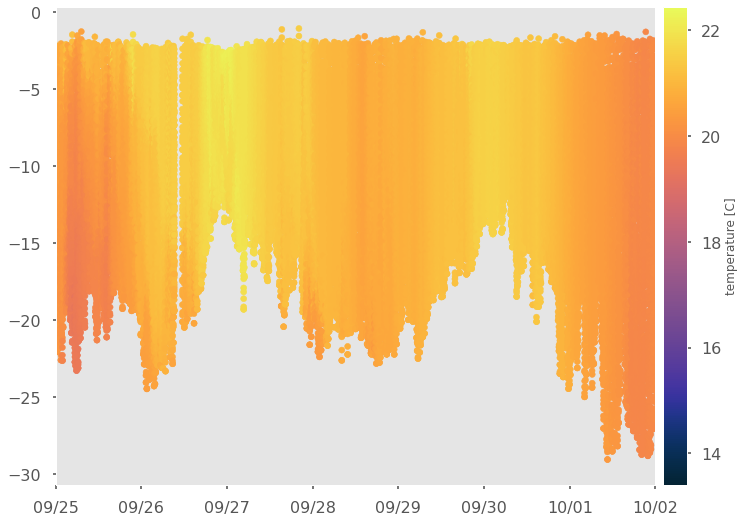

In [44]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
myFmt = mdates.DateFormatter('%m/%d')
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

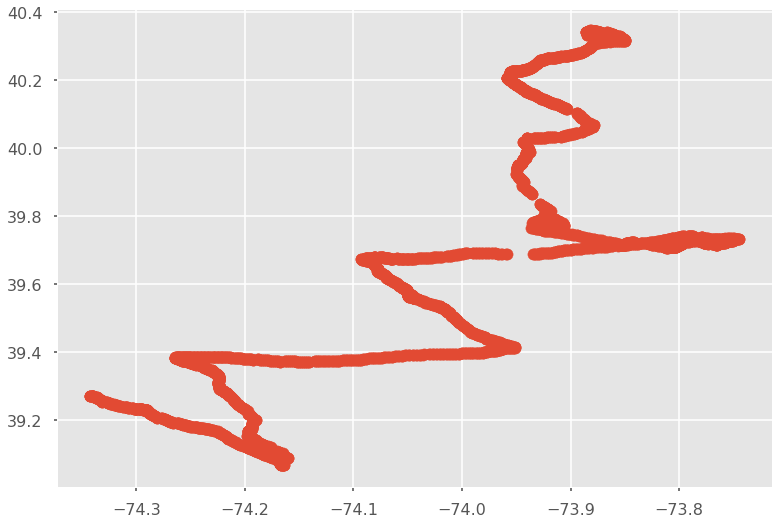

In [45]:
plt.scatter(df.longitude, df.latitude)

In [35]:
print(df.mdate.shape, df.depth.shape)

D, MDATE = np.meshgrid(df.depth.values,df.mdate.values)

AttributeError: 'Dataset' object has no attribute 'mdate'

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


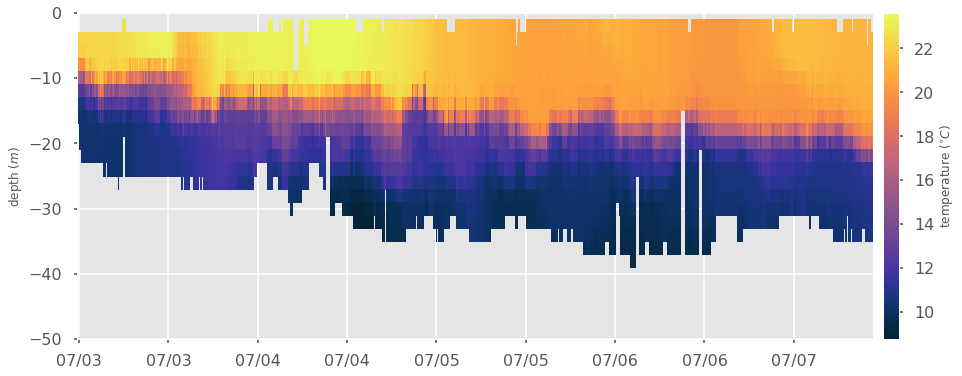

In [19]:
plt.figure(figsize=(17,6))
plt.pcolor(MDATE, D, df.temperature, cmap=cmo.thermal)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-50,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [26]:
winddata = "../data/cman4h2014.txt"

In [27]:
ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)

In [28]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

In [37]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
#ndb['datenum'] = ndb_datenum
start = mdates.date2num(datetime.datetime(2014,7,1))
enddd = mdates.date2num(datetime.datetime(2014,7,7))

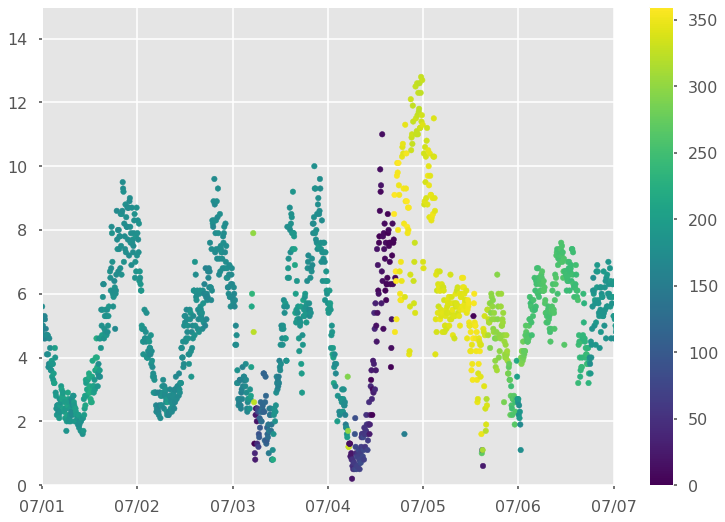

In [45]:
plt.scatter(ndb_datenum, ndb['WSPD'], c=ndb['WDIR'], s=30, vmin=0, vmax=360)
plt.colorbar()
plt.ylim([0, 15])
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)

(16252.0, 16258.0)

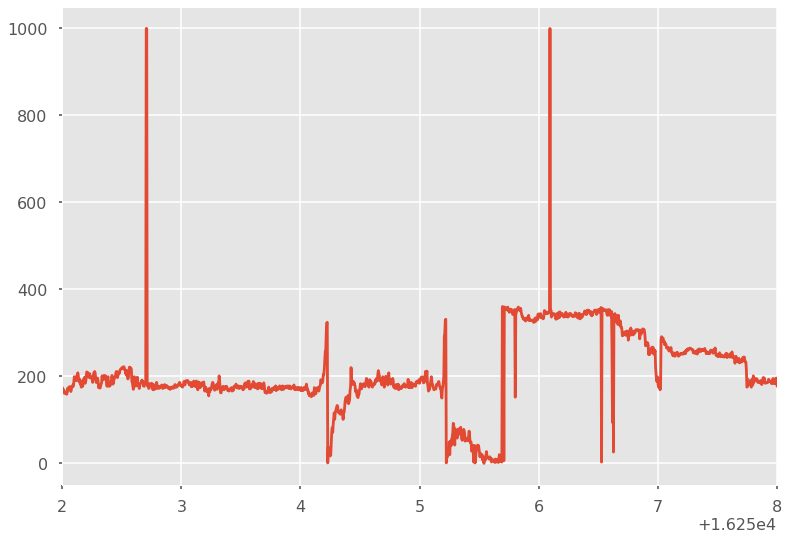

In [44]:
plt.plot(ndb_datenum,ndb['WDIR'])
plt.xlim([start, enddd])